## Photometric catalogs - Part 2: Cluster photo-z with Rubin data.

C. Stubbs, Feb 14, 2025
Andrés A. Plazas Malagón, Sep. 26, 2025,
With assistance from ChatGPT and Gemini.

### **Overview**

This is the second of a pair of notebooks that provide a database of photometry, size measurements, and photometric uncertainties for sources around the galaxy clusters **Abell 1942** and **Abell 360**.

In the first notebook, we used SDSS data of Abell cluster 1942 to learn how to separate galaxies from stars, and how to use galaxy counts as a function of brightness to test cosmological predictions.  

In this second notebook about large scale structure, we'll use Rubin data around cluster Abell 360 to select red galaxies that are likely cluster members.   

And here is a link to an image of Abell 360:  
[Legacy Survey Viewer](https://www.legacysurvey.org/viewer#abell%20360)  

*(type "Abell 360" in the search bar and then zoom in a bit).*  

### **Learning Objectives**

After working through these notebooks you will have a good feel for how astronomers work with catalogued datasets that contain parametric descriptors for celestial objects. We start with broadband images of the sky taken in different optical and infrared passbands. Software is used to identify and characterize sources, and merge the detections into assigned attributes of distinct objects.

You'll learn how to discriminate between stars and galaxies, using shape and flux information.

You'll have the chance to fit models to data, and to compare cosmological predictions with observations.

You'll learn how to select out a subset of objects from a parent catalog, and make a color-magnitude diagram for galaxies (!). You'll then play around with selecting a best-size aperture within which to select cluster members, and use their mean color to estimate the redshift of Abell 360.

### **Submitting Your Work**  

As you work through this, you'll see places where you're asked to answer questions or to enter data. This is done by editing the appropriate text cell.

You'll upload your version of this finished notebook to Canvas,
with the file name

***ClusterLRG_Part2_LastFirst_LastFirst.ipynb***

where the LastFirst names are the team members.
Go ahead and save this now, in accord with that naming convention.

### Tips and Hints

We'll make liberal use of the Gemini AI agent that is embedded in Colab. Make sure you understand the difference between the genric chat bot you invoke with the icon at the top right, vs. the one that interacts more directly with code cells.

In some of the code cells I've left in the prompt that was used to intially create the cell. In many cases it was lightly edited after that initial creation, though.

Remember you can click on the three dots on the right of a code cell and have it "Explain Code" to you.

Places we are seeking your input are flagged like this:

<font color="red"> **your input needed here** </font>

### **Why Rubin?**

The *Vera C. Rubin Observatory* and the *Legacy Survey of Space and Time (LSST)* will be the most ambitious wide-field imaging survey ever undertaken. Its photometric catalog will contain tens of billions of galaxies and stars, and it will repeatedly scan the southern sky for a decade. This survey is a natural next step after SDSS, providing much deeper, wider, and time-domain coverage.

Open the Gemini chat window with the icon in the top right of the browser interface. Then cut-and-paste this into the Gemini chat window:

---

**Prompt** *Tell me about the Rubin Observatory and the Legacy Survey of Space and Time (LSST). How many objects will it measure? What is its sky coverage and survey duration? What telescope and camera does it use? I’m told it will scan the sky repeatedly in multiple bands—how often will each part of the sky be observed, and to what depth? I’m also told it will create a massive time-domain dataset—how are alerts generated for variable and transient sources?*


---

---

### **Data File**

You will be using the data file **`abell360_rubin_dp1.fits`**, which contains data from Rubin Observatory Data Preview 1 ([see documentation](https://dp1.lsst.io/)).  

The data were obtained via the Rubin Science Platform (you may have account there at `data.lsst.cloud` if you want to explore more Rubin data and run more [tutorials](https://dp1.lsst.io/tutorials/notebook/index.html)) using the following Astronomical Data Query Language (ADQL) query:

```sql
SELECT obj.objectId, obj.coord_ra, obj.coord_dec,

       -- g-band
       obj.g_extendedness, obj.g_cModelFlux, obj.g_cModelFluxErr,
       obj.g_cModelMag, obj.g_cModelMagErr,
       obj.g_psfFlux, obj.g_psfMag, obj.g_psfMagErr,

       -- r-band
       obj.r_extendedness, obj.r_cModelFlux, obj.r_cModelFluxErr,
       obj.r_cModelMag, obj.r_cModelMagErr,
       obj.r_psfFlux, obj.r_psfMag, obj.r_psfMagErr,

       -- i-band
       obj.i_extendedness, obj.i_cModelFlux, obj.i_cModelFluxErr,
       obj.i_cModelMag, obj.i_cModelMagErr,
       obj.i_psfFlux, obj.i_psfMag, obj.i_psfMagErr

FROM dp1.Object AS obj
WHERE
    -- Spatial cut
    CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec),
             CIRCLE('ICRS', {cluster_ra}, {cluster_dec}, {radius})) = 1

    -- cModel and Kron flags must be zero
    AND obj.g_cModel_flag = 0 AND obj.g_kronFlux_flag = 0
    AND obj.r_cModel_flag = 0 AND obj.r_kronFlux_flag = 0
    AND obj.i_cModel_flag = 0 AND obj.i_kronFlux_flag = 0

    -- PSF quality flags
    AND obj.g_pixelFlags_inexact_psfCenter = 0
    AND obj.r_pixelFlags_inexact_psfCenter = 0
    AND obj.i_pixelFlags_inexact_psfCenter = 0
```

Cut and paste the query into the Gemini chat window, along with the following prompt:

---

**Prompt** *Please explain in detail the query I pasted and the meaning of each column and operation. Explain what a database is, and what SQL and ADQL are in the context of astronomy and Rubin Observatory data.*

---
---

The file needs to be placed on your Google Drive in the same directory where your notebook is stored. You can fetch it from the course site. First put it on your local computer, then go to your Google Drive folder and use File Upload to send it there.  

You can also upload it directly to the notebook from your computer.

We are going to use measurements of the apparent brightness of objects in a data file centered on RA=37.865 and DEC=+6.982.

---

Explore Rubin Data from First Light: https://skyviewer.app/


### **Expected Data Structure**
- A structured table with:
  - **RA, Dec** (coordinates)  
  - **Object ID**  
  - **PSF Magnitudes & Uncertainties** in *g, r, i* bands  
  - **cModel Magnitudes & Uncertainties (same bands)**  
  - Shape measurements (for some objects) and flags  

### **Photometry of Point Sources and Extended Sources**

As seen from a ground-based telescope, point sources (such as stars) are blurred by turbulence in the atmosphere (what astronomers call *seeing*). These point sources produce two-dimensional Gaussian-like flux distributions on the focal plane. That 2-D distribution is called the Point Spread Function (PSF). Adding up the flux within the PSF model produces a measured quantity called the **PSF magnitude**, along with its associated uncertainty.  

Extended sources, like galaxies, produce light profiles that are wider than the PSF. Astronomical codes measure their brightness using models that combine simple analytic profiles (typically an exponential disk plus a de Vaucouleurs bulge). The LSST Science Pipelines use such a combination, and the resulting measurement is called the **cModel magnitude** (instead of the Petrossian magnitudes for SDSS in notebook 1).   

- For unresolved objects (point sources), the cModel and PSF magnitudes will be nearly identical.  
- For resolved galaxies, the cModel magnitude generally captures more flux than the PSF magnitude, because the galaxy’s light profile extends beyond the PSF width.  

Cut and paste this prompt into the Gemini chat box:  

---

**Prompt:** *Please give me a quick summary of how cModel magnitudes work in Rubin/LSST, and why they are a good method for measuring the apparent magnitudes of galaxies. For a star, are the cModel and PSF magnitudes the same? What about for resolved galaxies? Also, remind me what a 'resolved' object means. Finally, tell me why a combination of exponential and de Vaucouleurs profiles is used.*  

---


Load this Rubin DP1 file from Canvas onto your laptop and then into your Colab Notebooks directory, **abell360_rubin_dp1_303_1_galaxy_photometry_v6.fits**

You can either do that by hand, or use the cell below to move it from your laptop onto the remote Google server.

In [ ]:
from google.colab import files
uploaded = files.upload()

Let's define a high signal-to-noise ratio (SNR) galaxy and star samples, using the cuts derived in an anlogous way to what was done with SDSS data in Noteboook 1.

In the Rubin DP1 catalog, galaxy and PSF magnitudes and their associated errors are calculated as `r_cModelMag`, `r_cModelMagErr`, `r_psfMag`, `r_psfMagErr` (and the same for other bands).

In [13]:
from astropy.table import Table
import pandas as pd

# Read FITS file into an Astropy Table
obj_cat = Table.read("abell360_rubin_dp1_303_1_galaxy_photometry_v6.fits")

# Convert to Pandas DataFrame
FullCatalog_df = obj_cat.to_pandas()

# Apply SNR cut: keep objects with r-band cModel magnitude error <= sigma_mag_cut mag
sigma_mag_cut = 0.05
HighSNR_df = FullCatalog_df[FullCatalog_df['r_cModelMagErr'] <= sigma_mag_cut].copy() # Explicitly create a copy

# Select galaxies: those with |drmag| > star_galaxy_cut
star_galaxy_cut = 0.05
HighSNR_df['drmag'] = HighSNR_df['r_psfMag'] - HighSNR_df['r_cModelMag']
stars = HighSNR_df[HighSNR_df['drmag'].abs() < star_galaxy_cut]
galaxies = HighSNR_df[HighSNR_df['drmag'].abs() >= star_galaxy_cut]

## Stellar Locus
We can take the complement of what was done in Notebook 1 which worked with galaxies, and now work with stars. Crudely, the colors of a star (differences in magnitudes observed in different filters, which are actually flux ratios since magnitudes are lograithmic quantities, as shown in Notebook 1) are primarily a function of temperature. That implies that in a 2-d plot of color${_i}$-color${_j}$, stars should form a single locus of points.

This clustering of points in color-color space is called the Stellar Locus, and it's useful for many purposes, such as photometric calibration, correcting for atmospheric and Galactic extinction, stellar classification, and star-galaxy discrimination.

The next cell makes a plot of the hockey-stick looking stellar locus for our catalog of sources, in (g-r) vs. (r-i) space.

We used this to calibrate observations for measuring photometric redshifts to galaxy clusters detected from the South Pole Telescope through distortions in the cosmic microwave background. See
https://iopscience.iop.org/article/10.1088/0004-6256/138/1/110/meta

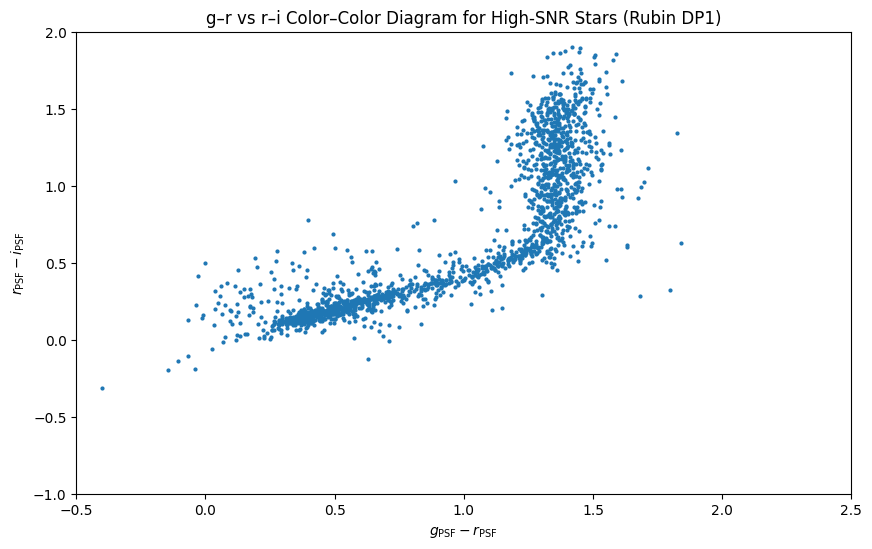

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# In a previous cell, we selected high SNR stars based on the condition |drmag| <= star_galaxy_cut

# Create the plot (color–color diagram using PSF magnitudes)
plt.figure(figsize=(10, 6))
plt.plot(stars['g_psfMag'] - stars['r_psfMag'],
         stars['r_psfMag'] - stars['i_psfMag'],
         'o', markersize=2)

plt.xlabel(r'$g_{\rm PSF} - r_{\rm PSF}$')
plt.ylabel(r'$r_{\rm PSF} - i_{\rm PSF}$')
plt.xlim(-0.5, 2.5)
plt.ylim(-1, 2)
plt.title('g–r vs r–i Color–Color Diagram for High-SNR Stars (Rubin DP1)')
plt.show()



**Colors of Large Red Elliptical Galaxies (LRGs)**

As we've seen, the Balmer break is a distincitive feature in the spectrum of elliptical galaxies. This means that as a function of redshift the colors of those galaxies change. Conversely, the observed color can give us a photometric redshift (photo-z) estimate. Since elliptical galaxies preferentially populate galaxy clusters, if we can select cluster LRG members based on their spatial location, colors, and magnitudes we could obtain a redshift estimate for the cluster. That of course needs to be calibrated based on spectroscopic data, but we'll come to that below.

## Looking for Cluster Galaxies ##
The data file we have is centered on the known galaxy cluster Abell 360. Let's look at the colors and magnitudes of the high SNR galaxies as a function of their distance from the center of the cluster. The cell below makes an interactive plot with two sliders. This allows us to select galaxies within an annulus between R and dR. Setting R=0 selects galaxies within dR of the cluster center. Setting R to a larger value selects objects away from the cluster center.

Run the cell below and get a sense of how it works. Change the sliders and watch the plot adjust accordingly.

Then, for different settings of R and dR, run the cell below the plot. It makes a fit to color vs. magnitude and reports the g-r color evaluated at i=18th mag, as well as the dispersion (standard deviation) of the points around the fit line.

Using the interacive plot and the cell below it, which operates on the selected galaxies, fill in this table:

<font color="red"> **your input needed here** </font>

\begin{array}{|c|c|c|c|c|c|}
R (arcmin) & dR (arcmin) & Ngal & g-r~at~i=18 & \sigma_{residuals} & Notes \\
\hline
0 & 1 & edit~here & edit~here & edit~here & really~small~circle~centerd~on~cluster\\
0 & 2 & edit~here & edit~here & edit~here & small~circle~centerd~on~cluster\\
0 & 5 & edit~here & edit~here & edit~here & larger~aperture \\
0 & 10 & edit~here & edit~here & edit~here & and~larger~still \\
0 & 30 & edit~here & edit~here & edit~here & this~is~entire~catalog\\
10 & 5 & edit~here & edit~here & edit~here & excludes~cluster\\
10 & 15 & edit~here & edit~here & edit~here & excludes~cluster\\
\end{array}

 Bearing in mind that the typical angular size of a galaxy cluster is a few arcminutes, we can see the tradeoffs. Too small a radius gives us too few galaxies, but in the limiting case where dR is 30 arcmin the structure of the cluster members is washed out by background ('field') galaxies.

The image below shows how R and dR are defined, to establish an annulus to select the objects that are plotted.

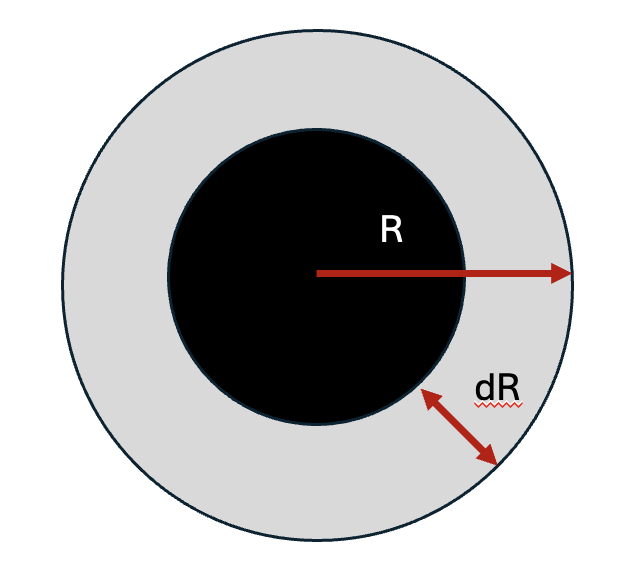

First, let's define a column with the separation of the galaxies from the cluster center, approximated by the location of the Brightest Cluster Galaxy (BCG).

In [15]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Define cluster center (BCG coordinates, in degrees)
ra_bcg, dec_bcg = 37.83, 6.98

# Compute angular separation in arcminutes
bcg_coord = SkyCoord(ra=ra_bcg*u.deg, dec=dec_bcg*u.deg)
obj_coords = SkyCoord(ra=galaxies['coord_ra'].values*u.deg,
                      dec=galaxies['coord_dec'].values*u.deg)

# Create a copy of the DataFrame slice to avoid the warning
galaxies_copy = galaxies.copy()

galaxies_copy['sep_arcmin'] = obj_coords.separation(bcg_coord).arcmin

# Quick check
print(galaxies_copy[['coord_ra','coord_dec','sep_arcmin']].head())

# Reassign the modified copy back to the original variable name if needed for subsequent cells
galaxies = galaxies_copy

     coord_ra  coord_dec  sep_arcmin
1   37.945569   6.720980   16.997879
2   37.942199   6.722994   16.806581
7   37.885135   6.824755    9.876706
9   37.976559   6.824953   12.757450
12  37.920233   6.826215   10.678367


## Cluster-Member LRG Color Estimation
We need to pick an aperture within which we hope the majority of the objects are cluster members. If we take advantage of the color uniformity of Large Red Galaxies (LRGs) then we look for the lowest dispersion in the data points around our fit in the color-magnitude diagram we make above. Take a look at the data table you filled out. At what aperture (dR) is $\sigma_{residuals}$ lowest? What's the value of g-r at i=18 for that dR?

Best-guess at LRG member g-r color:
<font color="red"> **your input needed here** </font>

Estimated uncertainty (OK to just estimate this):
<font color="red"> **your input needed here** </font>

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
%matplotlib inline

# Assuming galaxies DataFrame is already loaded
# and has a column "sep_arcmin" for cluster-centric radius in arcmin

# Create sliders for R and dR
R_slider = widgets.FloatSlider(min=0, max=30, step=0.1, value=0, description='R (arcmin):')
dR_slider = widgets.FloatSlider(min=0, max=30, step=0.1, value=1, description='dR (arcmin):')

# Define the update function
def update_plot(R, dR):
    # Select galaxies within the specified annulus
    selected_galaxies = galaxies[
        (galaxies['sep_arcmin'] >= R) & (galaxies['sep_arcmin'] < R + dR)
    ].copy()

    Ngal = len(selected_galaxies)

    # Calculate color errors: quadrature sum of g- and r-band errors
    selected_galaxies['e_g_minus_r'] = np.sqrt(
        selected_galaxies['g_cModelMagErr']**2 +
        selected_galaxies['r_cModelMagErr']**2
    )

    # Create the plot with errorbars
    plt.figure(figsize=(8, 6))
    plt.errorbar(selected_galaxies['i_cModelMag'],
                 selected_galaxies['g_cModelMag'] - selected_galaxies['r_cModelMag'],
                 yerr=selected_galaxies['e_g_minus_r'],
                 fmt='o', markersize=2, capsize=2)

    plt.xlabel(r'$i_{\rm cModel}$ (mag)', fontsize=12)
    plt.ylabel(r'$g_{\rm cModel} - r_{\rm cModel}$ (mag)', fontsize=12)
    plt.title(f'(R={R:.1f} to {R + dR:.1f} arcmin, Ngal={Ngal})', fontsize=14)
    plt.xlim(17, 22)
    plt.ylim(-0.5, 4)
    plt.gca().invert_xaxis()  # Invert x-axis to put bright objects on the left
    plt.show()

# Create the interactive plot
widgets.interact(update_plot, R=R_slider, dR=dR_slider);


interactive(children=(FloatSlider(value=0.0, description='R (arcmin):', max=30.0), FloatSlider(value=1.0, desc…

##Let's do a fit to the selected galaxies and find the g-r color at 18th magnitude##
This next cell defines a line in (g-r) vs. i. We'll also display the fitted line and print out the g-r color at i-18.

Using 1039 galaxies out of 1039 after filtering NaNs/Infs.
For R and dR of: 0.500, 8.300 arcmin
  
Number of galaxies used in the fit: 1039 (out of 1039 in annulus)
g-r fit at i_cModelMag = 18: 1.204 mag
Standard deviation of residuals: 0.330 mag
  
  


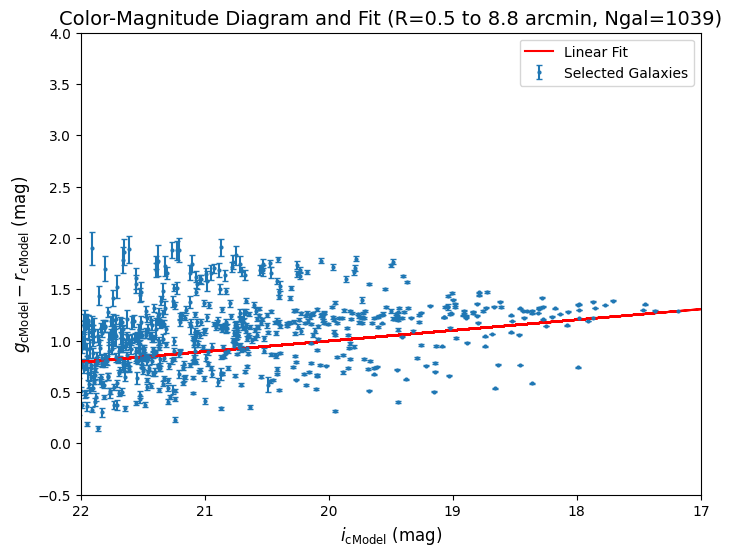

In [23]:
%matplotlib inline

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the fitting function (linear relation between color and magnitude)
# This function takes the magnitude (x) and the fit parameters (a and b)
# and returns the predicted color (y = a + b*x).
def linear_fit(x, a, b):
    return a + b * x

# Select galaxies within the specified annulus, creating a copy
# This filters the 'galaxies' DataFrame based on the cluster-centric separation
# defined by the R and dR slider values from the previous interactive plot.
# .copy() is used to avoid the SettingWithCopyWarning when adding new columns later.
selected_galaxies = galaxies[
    (galaxies['sep_arcmin'] >= R_slider.value) &
    (galaxies['sep_arcmin'] < R_slider.value + dR_slider.value)
].copy()  # Explicit copy avoids chained assignment warnings

# Get the number of galaxies in the selected annulus
Ngal = len(selected_galaxies)

# Calculate color errors (quadrature sum of g- and r-band uncertainties)
# The error in the difference of two magnitudes is the square root of the
# sum of the squares of the individual magnitude errors.
selected_galaxies.loc[:, 'e_g_minus_r'] = np.sqrt(
    selected_galaxies['g_cModelMagErr']**2 +
    selected_galaxies['r_cModelMagErr']**2
)

# Prepare data for fit
# Extract the i-band cModel magnitude (x) and the g-r color (y)
x = selected_galaxies['i_cModelMag'].values
y = (selected_galaxies['g_cModelMag'] - selected_galaxies['r_cModelMag']).values
# Use the calculated color error as the uncertainty for the fit
sigma = selected_galaxies['e_g_minus_r'].values

# Filter out invalid entries (NaNs, Infs, or non-positive errors)
# This ensures that the curve_fit function only uses valid data points.
valid = (
    np.isfinite(x) &
    np.isfinite(y) &
    np.isfinite(sigma) &
    (sigma > 0)
)

x_fit = x[valid]
y_fit = y[valid]
sigma_fit = sigma[valid]

print(f"Using {len(x_fit)} galaxies out of {len(x)} after filtering NaNs/Infs.")

# Perform weighted linear fit using scipy's curve_fit
# The 'sigma' parameter provides the uncertainties for each data point,
# and 'absolute_sigma=True' means these uncertainties are treated as absolute.
# popt contains the optimal values for the fitting parameters (a and b).
# pcov contains the covariance matrix of the parameters.
popt, pcov = curve_fit(linear_fit, x_fit, y_fit, sigma=sigma_fit, absolute_sigma=True)

# Evaluate the fit at i_cModelMag = 18
# This calculates the predicted g-r color at i=18th magnitude using the fitted line.
fit_at_18 = linear_fit(18, *popt)

# Calculate residuals
# The residuals are the differences between the observed y values and the
# values predicted by the fitted line.
residuals = y_fit - linear_fit(x_fit, *popt)

# Calculate standard deviation of residuals
# The standard deviation of the residuals gives a measure of the scatter
# of the data points around the fitted line.
std_residuals = np.std(residuals)

# Print results
print(f"For R and dR of: {R_slider.value:.3f}, {dR_slider.value:.3f} arcmin")
print("  ")
print(f"Number of galaxies used in the fit: {len(x_fit)} (out of {Ngal} in annulus)")
print(f"g-r fit at i_cModelMag = 18: {fit_at_18:.3f} mag")
print(f"Standard deviation of residuals: {std_residuals:.3f} mag")
print("  ")
print("  ")

# Plot the selected galaxies and the fit line
# This creates a scatter plot of the selected galaxies with error bars
# and overplots the linear fit line.
plt.figure(figsize=(8, 6))
plt.errorbar(x_fit, y_fit, yerr=sigma_fit, fmt='o', markersize=2, capsize=2, label='Selected Galaxies')
plt.plot(x_fit, linear_fit(x_fit, *popt), color='red', label='Linear Fit')
plt.xlabel(r'$i_{\rm cModel}$ (mag)', fontsize=12)
plt.ylabel(r'$g_{\rm cModel} - r_{\rm cModel}$ (mag)', fontsize=12)
plt.title(f'Color-Magnitude Diagram and Fit (R={R_slider.value:.1f} to {R_slider.value + dR_slider.value:.1f} arcmin, Ngal={Ngal})', fontsize=14)
plt.xlim(17, 22)
plt.ylim(-0.5, 4)
plt.gca().invert_xaxis()  # Invert x-axis to put bright objects on the left
plt.legend()
plt.show()

What do you think of that fit? Does it do a good job of representing the LRG population? There are three things we can do to improve it:
1) restrict the fit to i$<$20th magnitude. That will keep only the brighter galaxies,
2) include the uncertainty information in the fitting, using the inverse of the uncertainty to weight the data points when computing chi-squared, and
2) do what is called a 'robust fit', that iteratively performs a linear fit and rejects outliers.

See if you can iterate using AI to create a new cell that uses these methods to improve our estimate of (g-r) at i=18th, and report an uncertainty in that color as well.

## Photometric Redshift Estimation.##

The SDSS project has provided a calibration between LRG colors and redshifts.

Using the best-estimate g-r color for LRGs determined above, use this plot to read off an estimated redshift, based on the g-r color. You need to use the top panel in the plot. (plot reproduced from ) . https://iopscience.iop.org/article/10.1088/0004-637X/785/2/104/meta

Give an estimate of your photo-z uncertainty based on the uncertainty in g-r color at i=18.

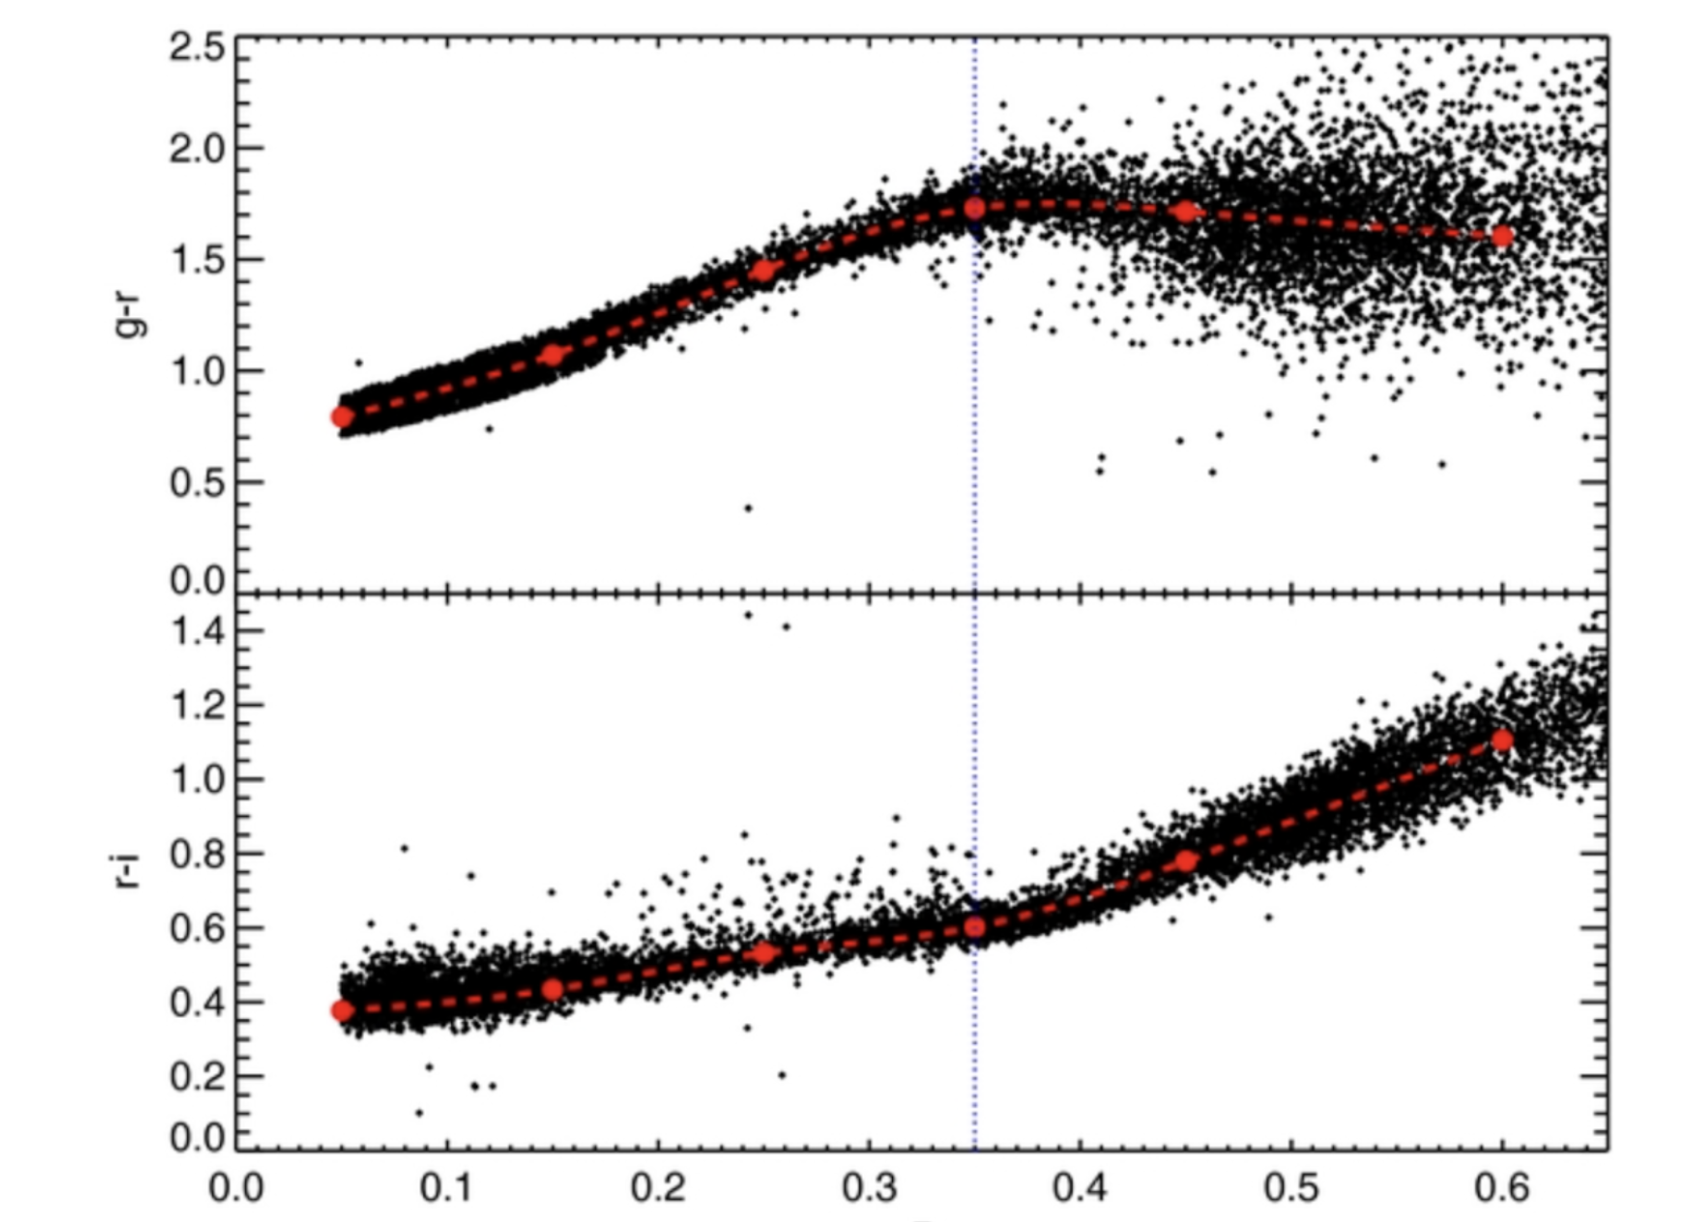

Read off your best estimate of the measurement of the redshift of the cluster, and an estimated uncertainty. Put your numbers down here:

Estimated photometric redshift, and uncertainty:

<font color="red"> **your input needed here** </font>

---

Abell 360 has a catalogued redshift of z=0.22. How did you do?

<font color="red"> **your input needed here** </font>

---

Why do you think, based on your knowledge of the spectrum of an elliptical galaxy, that beyond z=0.35 the r-i color becomes more useful than g-r?

<font color="red"> **your input needed here** </font>

### Acknowledgements

List the resources you used for this exercise, including any use of AI tools.

<font color="red"> **your input needed here** </font>

### **References** ###


Star-galaxy separation:
https://outerspace.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies



In [ ]:
# this is supposed to generate a PDF file of this on Google Drive.
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('ClusterLRG-Part2-Rubin-2025SEP26.ipynb')